##Классификация.

Вам предложен набор с признаками съедобных и несъедобных грибов.  
Набор разбит на две части:  
- тренировочный griby_train.csv
- тестовый griby_test.csv

**Задача:**  
1. загрузить данные
2. провести разведочный анализ данных:
    * определить количество признаков
    * определить тип признаков
    * проверить на наличие пропущенных значений
    * визуализировать данные - распределение по категориям для съедобных и несъедобных грибов
    * построить графики с помощью какого-либо из методов снижения размерности, например, метода главных компонент
3. построить классификатор, который как можно более точно предсказывает съедобность грибов на основе предложенных признаков с помощью:  
    * логистической регрессии
    * метода опорных векторов (для SVM важно проводить подбор гиперпараметров)
    * решающего дерева (и визуализировать дерево)
    * градиентного бустинга
4. для метода опорных векторов провести подбор оптимальных параметров
5. оценить качество полученных моделей с использованием тестового набора (accuracy, ROC AUC), построить графики для визуализации качества предсказаний 
6. оценить важность признаков
    



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # библиотека для построения графиков
import seaborn as sns # библиотека для построения графиков

from sklearn import preprocessing, decomposition, manifold, model_selection, pipeline, cluster, datasets, mixture, metrics

from sklearn import linear_model as lm
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, roc_curve, precision_score, roc_auc_score, f1_score

from sklearn.svm import LinearSVC, SVC

from IPython.display import Image

%matplotlib inline 

### 1. Загрузка данных

In [ ]:
## read test and train datasets:
data_train     = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Mushrooms/griby_train.txt', sep=',')
data_hold_out  = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Mushrooms/griby_test.txt', sep=',')

In [ ]:
data_train.head()

,class,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,poisonous,flat,scaly,brown,no,spicy,free,close,narrow,buff,tapering,?,smooth,silky,white,pink,partial,white,one,evanescent,white,several,leaves
1,poisonous,convex,scaly,yellow,no,foul,free,close,broad,gray,enlarging,bulbous,silky,silky,buff,pink,partial,white,one,large,chocolate,several,grasses
2,edible,convex,fibrous,brown,bruises,none,free,close,broad,pink,tapering,bulbous,smooth,smooth,pink,gray,partial,white,one,pendant,brown,solitary,woods
3,poisonous,convex,smooth,red,no,spicy,free,close,narrow,buff,tapering,?,smooth,silky,pink,pink,partial,white,one,evanescent,white,several,woods
4,edible,convex,fibrous,red,bruises,none,free,close,broad,brown,tapering,bulbous,smooth,smooth,white,gray,partial,white,one,pendant,black,solitary,woods


In [ ]:
data_train.columns

Index(['class', 'cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor',
       'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color',
       'stalk_shape', 'stalk_root', 'stalk_surface_above_ring',
       'stalk_surface_below_ring', 'stalk_color_above_ring',
       'stalk_color_below_ring', 'veil_type', 'veil_color', 'ring_number',
       'ring_type', 'spore_print_color', 'population', 'habitat'],
      dtype='object')

форма крышки, поверхность колпачка, цвет колпачка, «синяки», «запах»,
"прикрепление жабр", "расстояние между жабрами", "размер жабр", "цвет жабр", «форма стебля», «корень стебля», «поверхность стебля над кольцом», «поверхность стебля под кольцом», «цвет стебля над кольцом»,
«цвет стебля под кольцом», «тип вуали», «цвет вуали», «номер кольца»,«кольцевой тип», «цвет отпечатка спор», «популяция», «среда обитания»

*перевел для себя, чтобы понять, что за признаки*

### 2. Разведочный анализ данных

In [ ]:
## проверка на наличие пропущенных значений
data_train.replace('?', np.nan).isnull().sum() #для тренировочного датасета

class                         0
cap_shape                     0
cap_surface                   0
cap_color                     0
bruises                       0
odor                          0
gill_attachment               0
gill_spacing                  0
gill_size                     0
gill_color                    0
stalk_shape                   0
stalk_root                  614
stalk_surface_above_ring      0
stalk_surface_below_ring      0
stalk_color_above_ring        0
stalk_color_below_ring        0
veil_type                     0
veil_color                    0
ring_number                   0
ring_type                     0
spore_print_color             0
population                    0
habitat                       0
dtype: int64

Пропущенных значений нет, но есть ? в колонках.

In [ ]:
data_hold_out.replace('?', np.nan).isnull().sum() #для тестового датасета

class                         0
cap_shape                     0
cap_surface                   0
cap_color                     0
bruises                       0
odor                          0
gill_attachment               0
gill_spacing                  0
gill_size                     0
gill_color                    0
stalk_shape                   0
stalk_root                  311
stalk_surface_above_ring      0
stalk_surface_below_ring      0
stalk_color_above_ring        0
stalk_color_below_ring        0
veil_type                     0
veil_color                    0
ring_number                   0
ring_type                     0
spore_print_color             0
population                    0
habitat                       0
dtype: int64

In [ ]:
## сколько в датасете параметров? Признак class является целевым.
print(data_train.info(),'\n', data_hold_out.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2104 entries, 0 to 2103
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     2104 non-null   object
 1   cap_shape                 2104 non-null   object
 2   cap_surface               2104 non-null   object
 3   cap_color                 2104 non-null   object
 4   bruises                   2104 non-null   object
 5   odor                      2104 non-null   object
 6   gill_attachment           2104 non-null   object
 7   gill_spacing              2104 non-null   object
 8   gill_size                 2104 non-null   object
 9   gill_color                2104 non-null   object
 10  stalk_shape               2104 non-null   object
 11  stalk_root                2104 non-null   object
 12  stalk_surface_above_ring  2104 non-null   object
 13  stalk_surface_below_ring  2104 non-null   object
 14  stalk_color_above_ring  

По 22 признака

In [ ]:
## для каждого признака вывести количество наблюдений для каждой категории
## например, с помощью метода value_count
for i in data_train.columns:
  print(data_train[i].value_counts(), '\n')

print('------ \n')

for j in data_hold_out.columns:
  print(data_hold_out[j].value_counts(), '\n')


edible       1133
poisonous     971
Name: class, dtype: int64 

convex     974
flat       807
knobbed    198
bell       116
sunken       7
conical      2
Name: cap_shape, dtype: int64 

scaly      801
smooth     680
fibrous    623
Name: cap_surface, dtype: int64 

brown       569
gray        508
red         350
yellow      298
white       258
buff         51
pink         45
cinnamon     15
purple        5
green         5
Name: cap_color, dtype: int64 

no         1256
bruises     848
Name: bruises, dtype: int64 

none        944
foul        536
spicy       141
fishy       140
anise       109
almond      109
pungent      61
creosote     49
musty        15
Name: odor, dtype: int64 

free        2045
attached      59
Name: gill_attachment, dtype: int64 

close      1699
crowded     405
Name: gill_spacing, dtype: int64 

broad     1488
narrow     616
Name: gill_size, dtype: int64 

buff         413
pink         388
white        314
brown        267
gray         204
chocolate    198
purple 

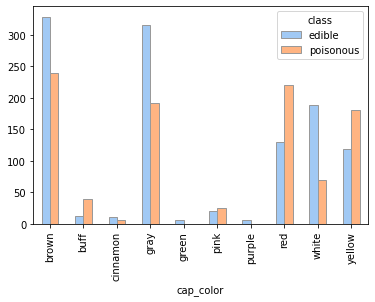

In [ ]:
## для визуализации распределения наблюдений по категориям
data_train[['cap_color','class']].groupby(['cap_color', 'class']).size().unstack().plot.bar(edgecolor=".6", #log= 'y',
                                                                                            color = sns.color_palette('pastel'));
## кстати, можно объединить data_train и data_test для построения графиков и анализа

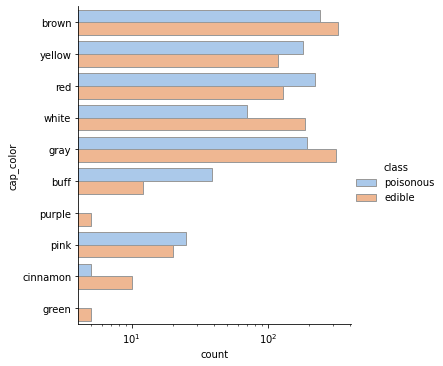

In [ ]:
sns.catplot(y="cap_color", hue="class", kind="count",
            palette="pastel", edgecolor=".6",
            data=data_train, log= 'x');

In [ ]:
## необходимо преобразовать признаки.
data_train_x = pd.get_dummies(data_train.drop(['class'], axis=1))
data_train_y = data_train['class'].replace(['poisonous', 'edible'], [0, 1])

data_test_x = pd.get_dummies(data_hold_out.drop(['class'], axis=1))
data_test_y = data_hold_out['class'].replace(['poisonous', 'edible'], [0, 1])

data_train_x, data_test_x = data_train_x.align(data_test_x, join='outer', axis=1, fill_value=0)

In [ ]:
data = pd.concat([data_train, data_hold_out])

data_x = pd.get_dummies(data.drop(['class'], axis=1))
data_y  = data['class'].replace(['poisonous', 'edible'], [0, 1])

In [ ]:
print('Столбцов в тренировочном датасете - ', data_train_x.shape[1],
      'Cтолбцов в тестовом датасете - ', data_test_x.shape[1])

Столбцов в тренировочном датасете -  117 Cтолбцов в тестовом датасете -  117


In [ ]:
## импортируем следующие функции из scipy:
## pdist - для определения расстояний между объектами (возвращает в конденсированном виде)
## squareform - для превращения матрицы расстояний в квадратную (избыточную)
from scipy.spatial.distance import pdist, squareform

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


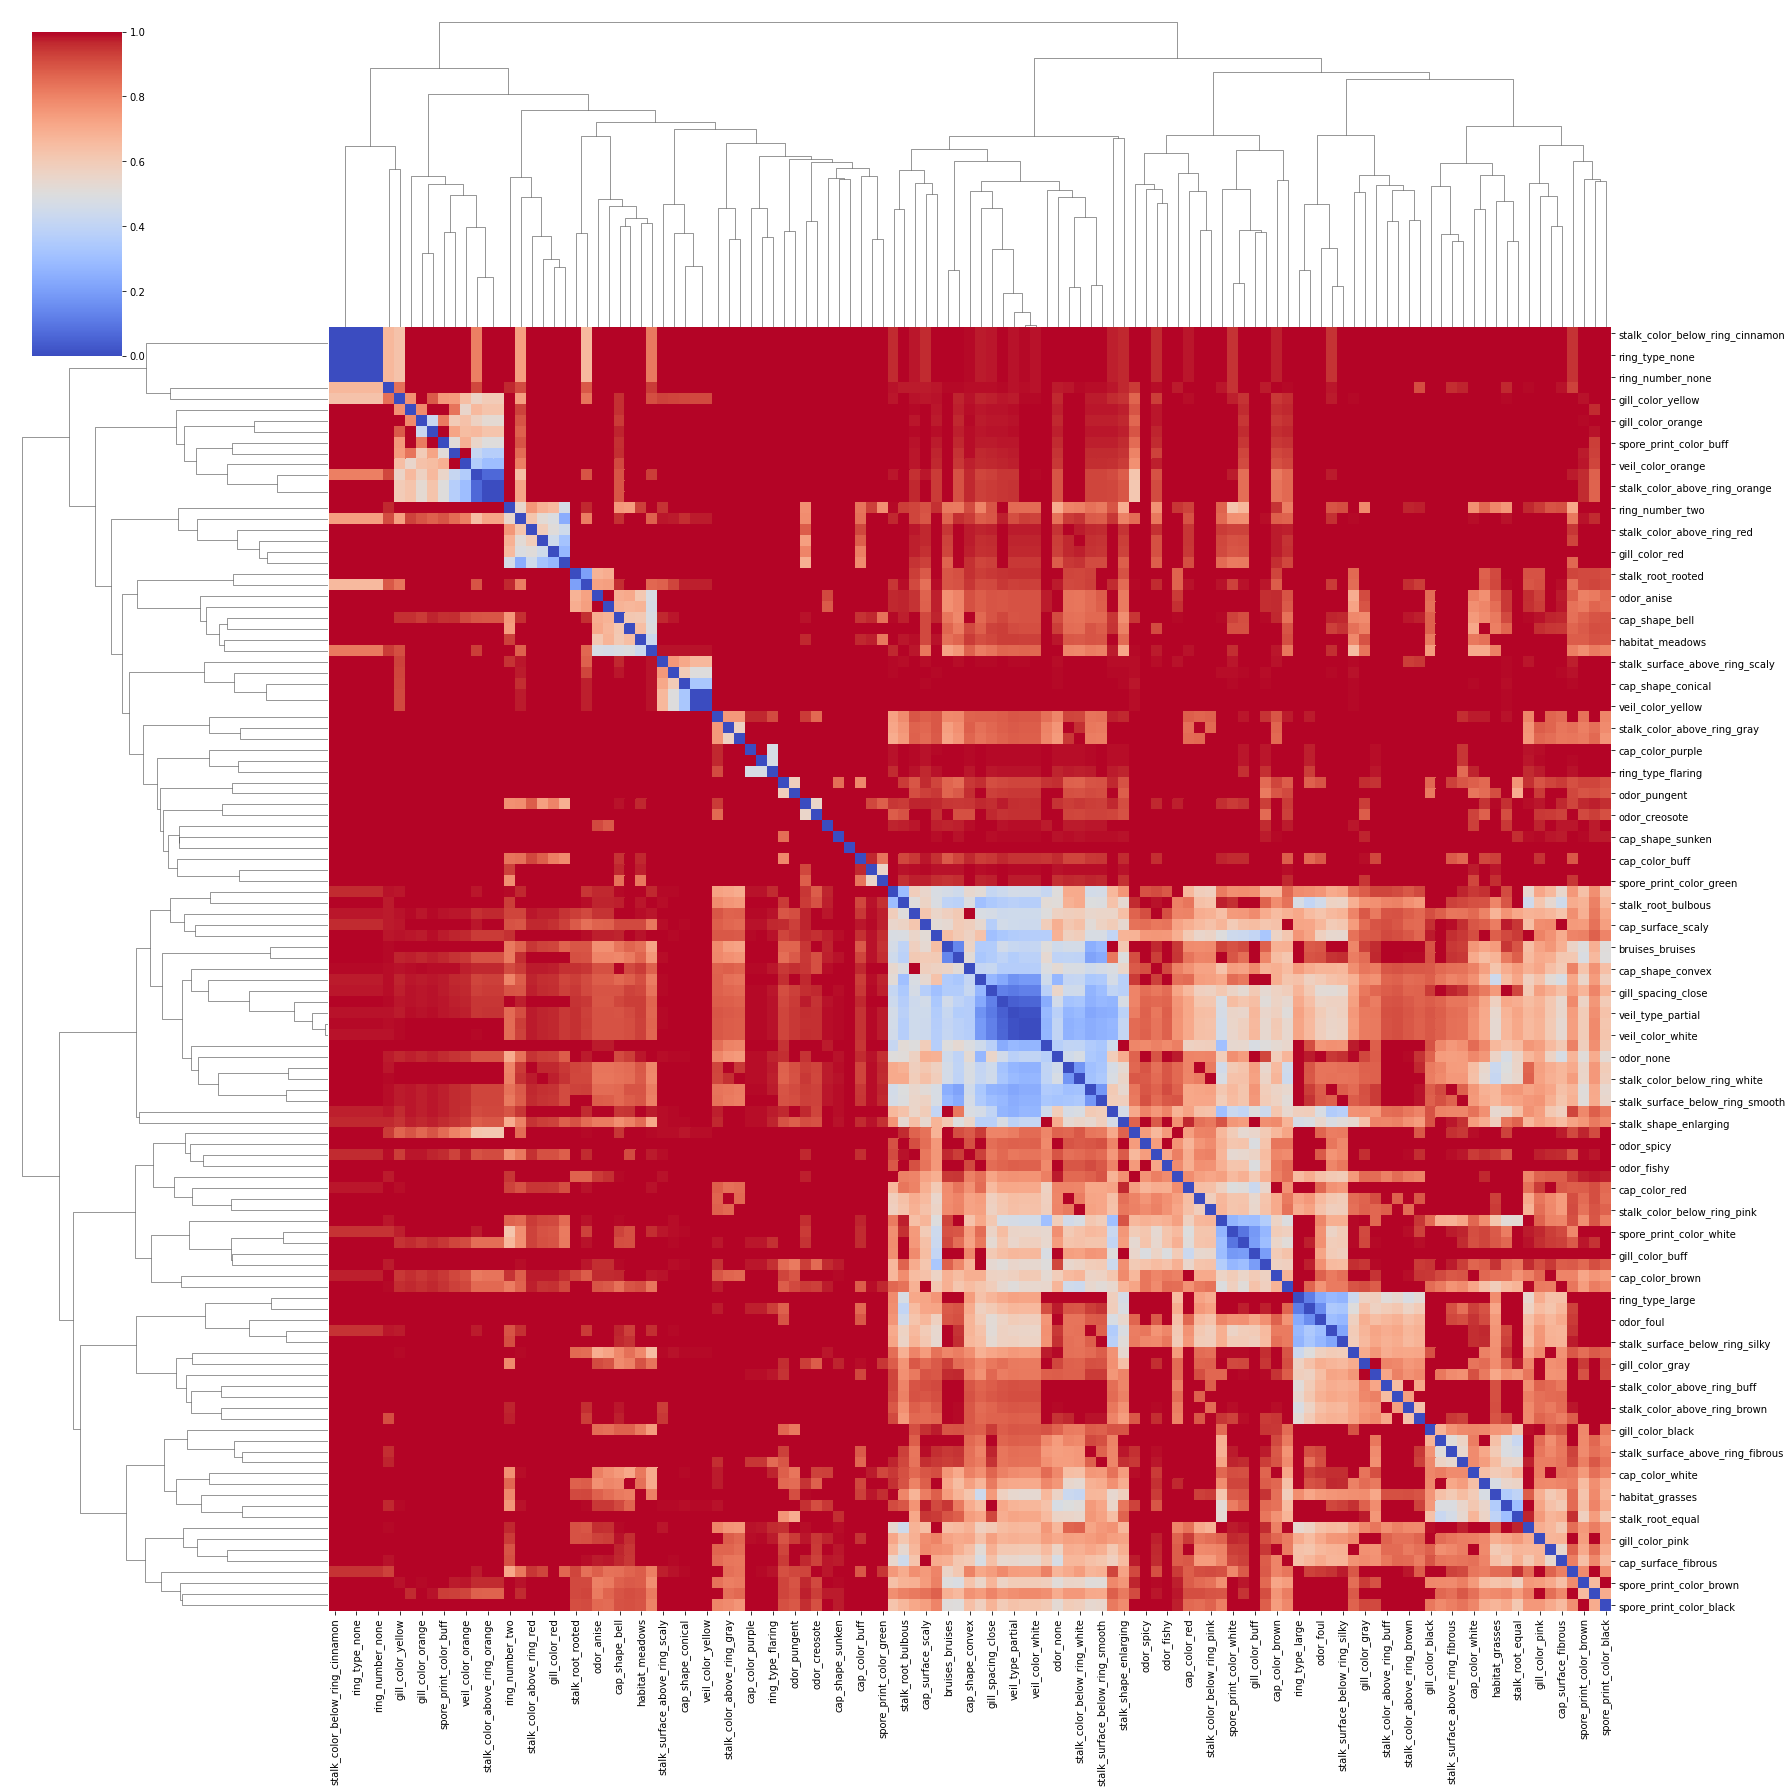

In [ ]:
## Далее приведена информация из документации к scipy.spatial.distance

## Computing distances over a large collection of vectors is inefficient for these functions. 
## Use pdist for this purpose.
## Distance functions between two numeric vectors u and v: 
##   braycurtis, canberra, chebyshev, cityblock, correlation, cosine, euclidean, jensenshannon, mahalanobis,
##   minkowski, seuclidean, sqeuclidean, wminkowski
## Distance functions between two boolean vectors (representing sets) u and v: 
##   dice, hamming, jaccard, kulsinski, rogerstanimoto, russellrao, sokalmichener, sokalsneath, yule

D = squareform(pdist(data_train_x.T.values, 'dice'))#'your_method')) ## матрица расстояний
## необходимо найти матрицу сходства
## создать на ее основе pandas.DataFrame, причем задать значения индекса и колонок, 
## соответствующие новым трансформированным признакам из таблицы shrooms_trainX
Sim = pd.DataFrame(D, index = data_train_x.columns, columns=data_train_x.columns)
## для функции seaborn.clustermap лучше дополнительно задать следующие параметры:
## cmap = 'coolwarm', figsize = (25, 25));
sns.clustermap(Sim, cmap = 'coolwarm', figsize = (25, 25));

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
Sc = StandardScaler().fit_transform(data_train_x.astype('float64'))
Data_X_sc = pd.DataFrame(Sc, index = data_train_x.index, columns=data_train_x.columns)

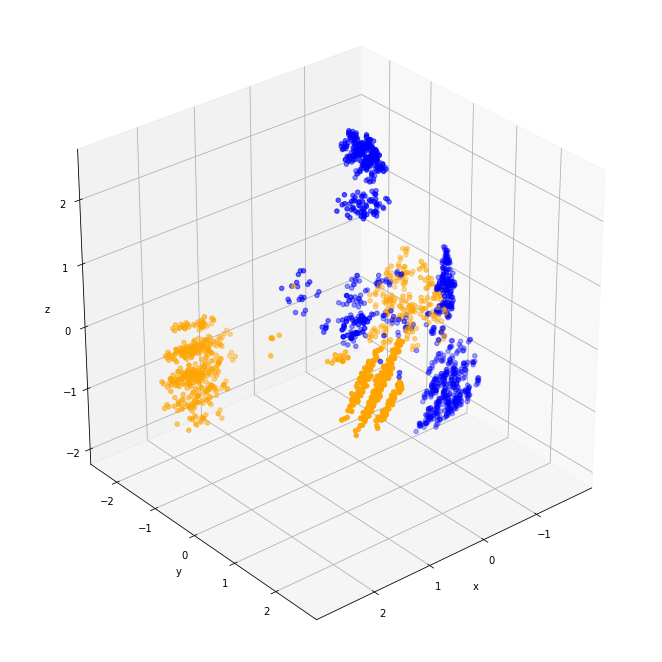

In [ ]:
## проведем снижение размерности наших данных с помощью PCA, MDS или другого метода
pca = PCA(n_components=3).fit(data_train_x)
scores = pd.DataFrame(pca.transform(data_train_x)[:, :3])
#x, y, z = scores[:,0], scores[:,1], scores[:,2] # если scores -- numpy.array
x, y, z = scores.iloc[:,0], scores.iloc[:,1], scores.iloc[:,2] # если scores -- pandas.DataFrame

class_cols = data_train_y.astype(str) # -- цвета, соответствующие меткам классов
class_cols = class_cols.replace('0', 'orange')
class_cols = class_cols.replace('1', 'blue')
from mpl_toolkits.mplot3d import Axes3D ## для построения 3D-графиков
fig = plt.figure(figsize = (9, 9)) ## зададим размер фигуры
ax = Axes3D(fig)

ax.scatter(x, y, z, color = class_cols) 

ax.view_init(30, 50) ## изменяя эти параметры вы меняете угол зрения
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');


### 3. Построение классификатора с помощью:
* логистической регрессии

In [ ]:
## создадим пайплайн
## или построим модель без создания пайплайна
## используем кросс-валидацию
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


def Model(clf):
  clf.fit(data_train_x, data_train_y)
  print("Точность на тестовом наборе: ", clf.score(data_test_x, data_test_y))
  score = cross_val_score(clf, data_x, data_y, scoring='jaccard')
  print("Кросс-валидация: ", score.mean())
  return clf



clf_lr = Model(LogisticRegression(solver='liblinear', penalty='l2'))

Точность на тестовом наборе:  0.9978880675818373
Кросс-валидация:  0.9975422369042001


* метода опорных векторов (для SVM важно проводить подбор гиперпараметров)

In [ ]:
## создадим пайплайн
## или построим модель без создания пайплайна
## используем кросс-валидацию
## лучше всего воспользоваться GridSearchCV или RandomizedSearchCV для подбора гиперпараметров
from sklearn.svm import SVC
clf_svc = Model(SVC())

Точность на тестовом наборе:  0.9989440337909187
Кросс-валидация:  0.9981538461538462


* решающего дерева (и визуализировать дерево — необязательно)

In [ ]:
clf_dt = Model(DecisionTreeClassifier(random_state=1000))

Точность на тестовом наборе:  1.0
Кросс-валидация:  0.9993846153846153


In [ ]:
!pip install graphviz

In [ ]:
from graphviz import Source
from sklearn import tree

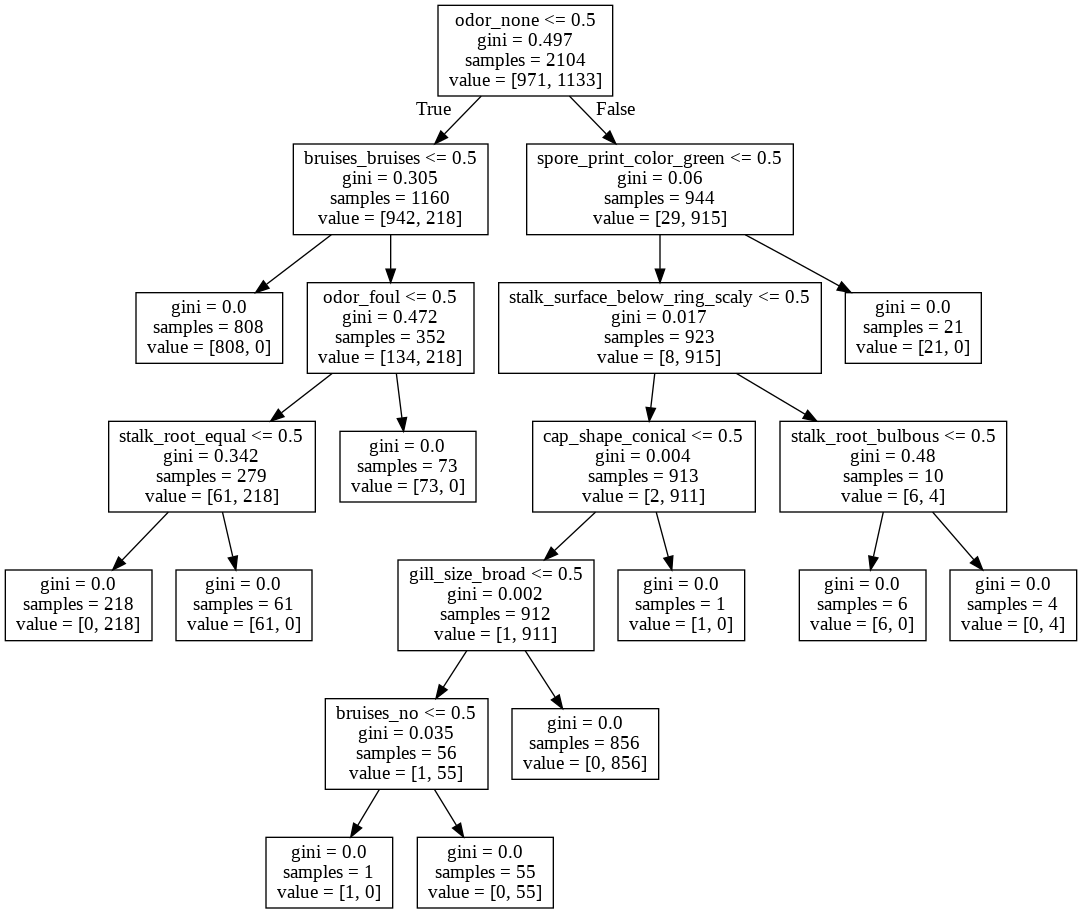

In [ ]:
graph = Source(tree.export_graphviz(clf_dt, out_file=None, feature_names=data_train_x.columns))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

* градиентного бустинга (или RandomForestClassifier, ExtraTreesClassifier)

In [ ]:
xgbc = Model(XGBClassifier(random_state=1000))

Точность на тестовом наборе:  1.0
Кросс-валидация:  1.0


### 4. Подбор оптимальных параметров (для SVM)

In [ ]:
cls_svc = SVC()
param_grid = [{'kernel': ['rbf'],
               'gamma': [1e-3, 1e-4],
               'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'],
               'C': [1, 10, 100, 1000]}]

clf_svc_gs = GridSearchCV(cls_svc, param_grid, cv=5)
clf_svc_gs.fit(data_train_x, data_train_y)
print(clf_svc_gs.best_params_)

score = cross_val_score(cls_svc, data_x, data_y, cv=5, scoring='jaccard')
print('Кросс-валидация: ',format(score.mean()))
cls_svc = Model(SVC(**clf_svc_gs.best_params_))

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Кросс-валидация:  0.9981538461538462
Точность на тестовом наборе:  1.0
Кросс-валидация:  1.0


### 5. Оценка качества полученных моделей с использованием тестового набора 
* Accuracy, ROC AUC, построить графики для визуализации качества предсказаний

Логистическая регрессия:  0.9978880675818373
Метод опорных векторов:  0.9989440337909187
Решающее дерево:  1.0
Градиентный бустинг:  1.0


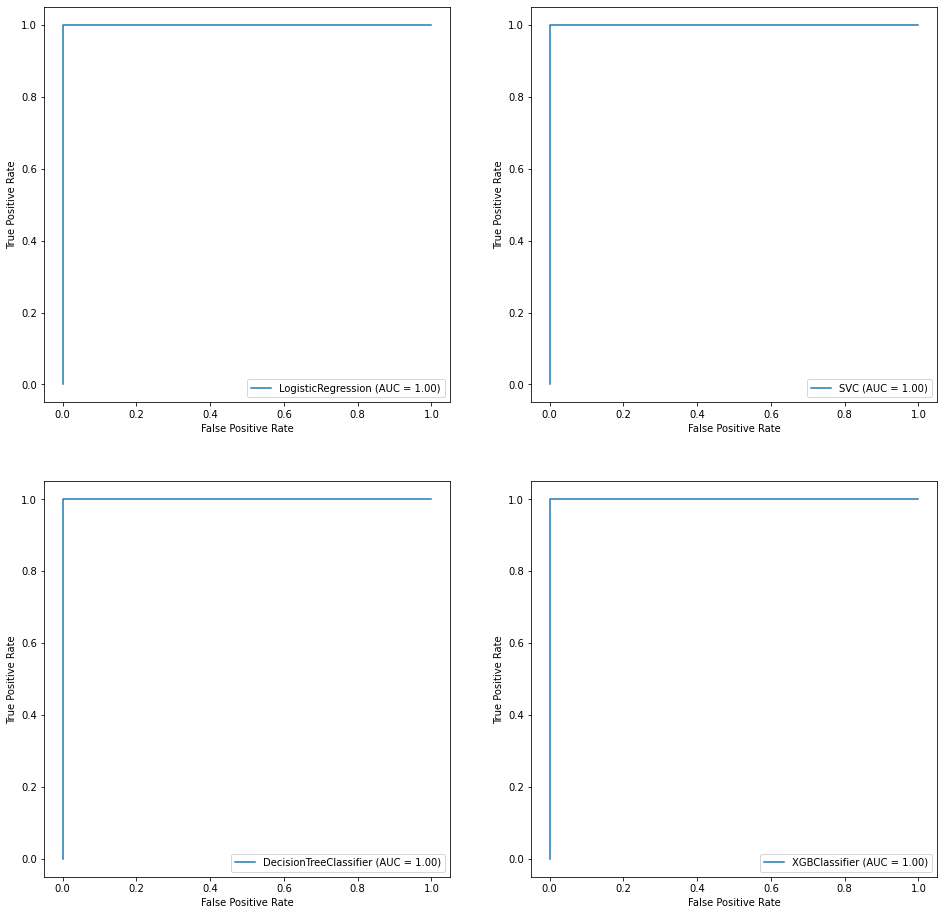

In [ ]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))

print('Логистическая регрессия: ', clf_lr.score(data_test_x, data_test_y))
print('Метод опорных векторов: ', clf_svc.score(data_test_x, data_test_y))
print('Решающее дерево: ', clf_dt.score(data_test_x, data_test_y))
print('Градиентный бустинг: ', xgbc.score(data_test_x, data_test_y))


metrics.plot_roc_curve(clf_lr,  data_test_x, data_test_y, ax=axes[0][0])
metrics.plot_roc_curve(clf_svc,  data_test_x, data_test_y, ax=axes[0][1])
metrics.plot_roc_curve(clf_dt,  data_test_x, data_test_y, ax=axes[1][0])
metrics.plot_roc_curve(xgbc,  data_test_x, data_test_y, ax=axes[1][1])

### 6. Оцените важность признаков

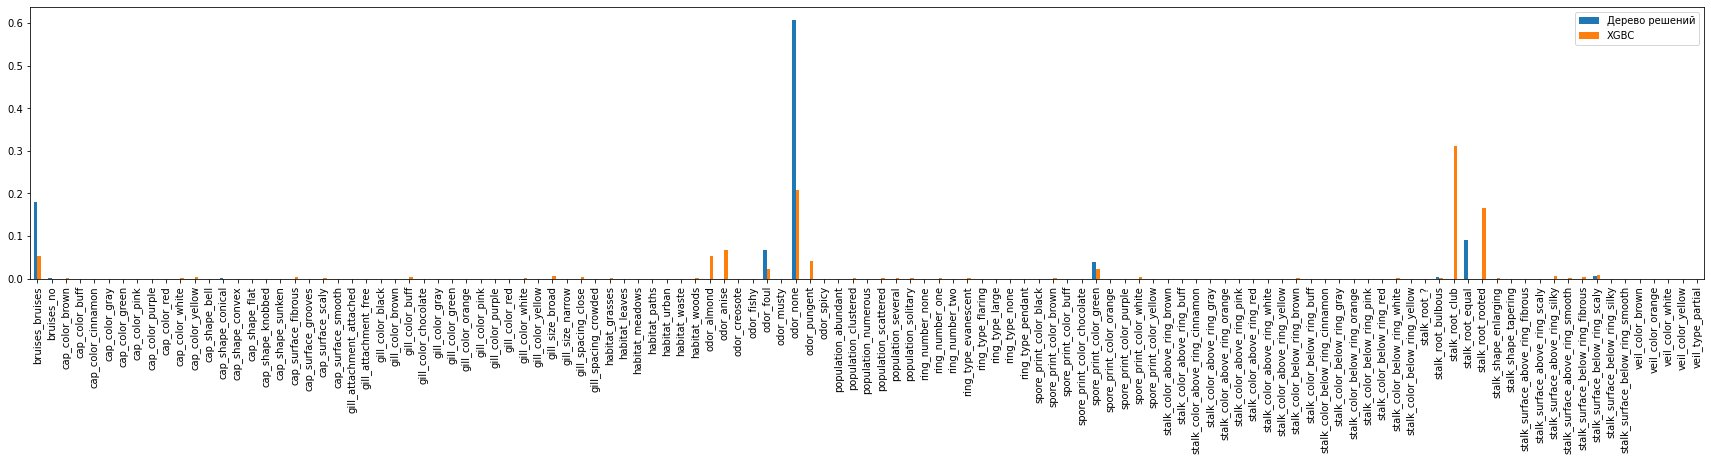

In [ ]:
features = np.array([clf_dt.feature_importances_, xgbc.feature_importances_]).T
df = pd.DataFrame(features, 
                  index = data_train_x.columns,
                  columns=['Дерево решений', 'XGBC'])

fig, axes = plt.subplots(figsize=(30,5))
df.plot.bar(ax=axes)

Самым важным признаком оказалось отсутствие запаха